# Importation des librairie

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from collections import Counter

Sélection du device pour bien utiliser le GPU avec CUDA

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Data Loading

In [ ]:
categories = ["airplane", "backpack", "car", "coffee_cup", "sailboat"]

airplane = np.load('/content/drive/MyDrive/Quickdraw/datasets/full_numpy_bitmap_airplane.npy')
backpack = np.load('/content/drive/MyDrive/Quickdraw/datasets/full_numpy_bitmap_backpack.npy')
car = np.load('/content/drive/MyDrive/Quickdraw/datasets/full_numpy_bitmap_car.npy')
coffee_cup = np.load('/content/drive/MyDrive/Quickdraw/datasets/full_numpy_bitmap_coffee cup.npy')
sailboat = np.load('/content/drive/MyDrive/Quickdraw/datasets/full_numpy_bitmap_sailboat.npy')

image = [airplane[:10000], backpack[:10000],car[:10000], coffee_cup[:10000], sailboat[:10000]]

In [ ]:
print(f"Nombre de point par image {len(image[0][0])}\n",
      f"Nombre de catégorie choisi {len(image)}\n",
      f"Nombre d'image par catégorie {len(image[0])}\n")

Nombre de point par image 784
 Nombre de catégorie choisi 5
 Nombre d'image par catégorie 10000



# Preprocessing des data

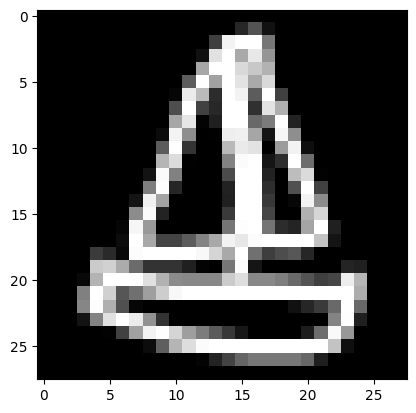

In [ ]:
pic = image[4][7].reshape(28, 28)
plt.imshow(pic, cmap='gray')
plt.show()

In [ ]:
# Création du DataFrame
source = {"Catégorie": [], "image": []}

for cat, arr in zip(categories, image):
    for val in arr:
        source["Catégorie"].append(cat)
        source["image"].append(val)

df = pd.DataFrame(source)

# Affichage du DataFrame
print(df)

      Catégorie                                              image
0      airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1      airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2      airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3      airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4      airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
...         ...                                                ...
49995  sailboat  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49996  sailboat  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49997  sailboat  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49998  sailboat  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49999  sailboat  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

[50000 rows x 2 columns]


In [ ]:
df['image'][0].shape

(784,)

# Préparation du CNN pour les images

In [ ]:
# Définir un dataset PyTorch personnalisé
class QuickDrawDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx]["image"]  # Array (784,)
        label = self.data.iloc[idx]["Catégorie"]  # Nom de la catégorie

        # Transformer l’image en tensor 1x28x28
        image = torch.tensor(image, dtype=torch.float32).view(1, 28, 28).to(device)

        # Transformer la catégorie en index numérique
        category_dict = {cat: i for i, cat in enumerate(self.data["Catégorie"].unique())}
        label = torch.tensor(category_dict[label], dtype=torch.long).to(device)

        return image, label

# Instancier le dataset et le DataLoader
train_dataset = QuickDrawDataset(df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("✅ Dataset QuickDraw prêt pour l’entraînement.")


✅ Dataset QuickDraw prêt pour l’entraînement.


In [4]:
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()  # Aplatir en un vecteur
        self.fc = nn.Linear(32 * 7 * 7, 128)  # Réduction à 128 dimensions

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.fc(x)  # Sortie = 128 dimensions
        return x  # Pas de softmax, on extrait juste les features

# Initialiser le CNN
cnn_model = FeatureExtractorCNN().to(device)
print("✅ CNN initialisé.")

✅ CNN initialisé.


Entrainement du modèle CNN pour une meilleur extraction des features

In [ ]:
# Définir un optimiseur et une fonction de perte
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Entraînement du modèle
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(images)  # On extrait les features
        loss = criterion(outputs, labels)  # On apprend à séparer les classes
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")
    losses.append(total_loss/len(train_loader))

# Sauvegarde du modèle entraîné
torch.save(cnn_model.state_dict(), "Learning_representation/src/models/fusion_model/quickdraw_cnn_10000.pth")
print("✅ Entraînement terminé et modèle sauvegardé.")


KeyboardInterrupt: 

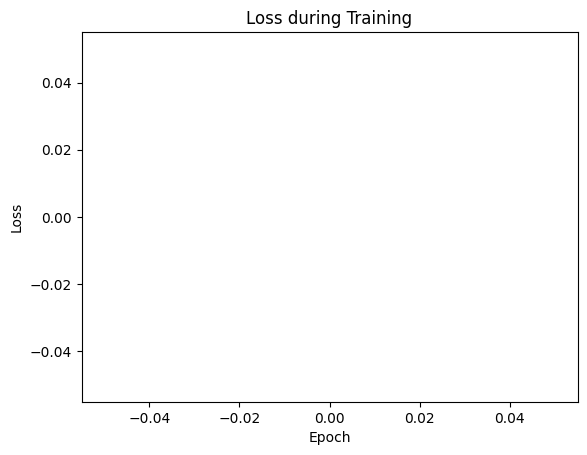

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.show()

In [6]:
# Charger le modèle entraîné
cnn_model.load_state_dict(torch.load("Learning_representation\src\models\fusion_model\quickdraw_cnn_10000.pth", map_location=torch.device('cpu')))
cnn_model.eval()

# Extraire les features d’une image
def extract_image_features(image_vector):
    image_tensor = torch.tensor(image_vector, dtype=torch.float32).view(1, 1, 28, 28).to(device)
    features = cnn_model(image_tensor).cpu().detach().numpy().reshape(128)
    return features

# Exemple d’extraction
image_features = extract_image_features(df.iloc[0]["image"])
print("Features extraites :", image_features, image_features.shape, df.iloc[0]["Catégorie"])  # (128,)

FileNotFoundError: [Errno 2] No such file or directory: 'Learning_representation\\src\\models\x0cusion_model\\quickdraw_cnn_10000.pth'

Préparation pour les questions

In [ ]:
# Différents modèles de questions
QUESTION_TEMPLATES = [
    "Peux-tu me dire si c'est un {} ?",
    "Est-ce un {} sur l'image ?",
    "L'image contient-elle un {} ?",
    "Y a-t-il un {} ici ?",
    "Ce dessin représente-t-il un {} ?",
    "On dirait un {}, non ?",
    "S'agit-il d'un {} ?",
]
switcher = {
        "airplane": "avion",
        "backpack": "sac",
        "car": "voiture",
        "coffee_cup": "tasse",
        "sailboat": "bateau",
    }

# Fonction pour générer une question aléatoire avec une catégorie aléatoire
def generate_random_question(true_category):
    category = random.choice(categories)  # Choisir une catégorie au hasard
    if category == true_category:
        category = true_category
    else:
        category = random.choice([category, true_category])
    template = random.choice(QUESTION_TEMPLATES)  # Choisir un modèle de phrase au hasard

    category_fr = switcher.get(category)
    return template.format(category_fr), category # return question and category

# Exemple
true_category = "airplane"
correct = 0
for i in range(100):
    question, category = generate_random_question(true_category)
    if category==switcher.get(true_category):
      correct += 1
print(correct)
print(question)  # Exemple : "L'image contient-elle un avion ?"
print(category)

0
S'agit-il d'un avion ?
airplane


In [ ]:
# Charger Word2Vec français
w2v_model = Word2Vec.load("/content/drive/MyDrive/data/word2vec_fr.model")

In [ ]:
# Fonction pour encoder une question
def encode_question(question):
    words = simple_preprocess(question) #convert a document into a list of token.
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

# Exemple
question = "Y a-t-il un avion ici ?"
question_vector = encode_question(question)
print("Feature de la question :", question_vector.shape)  # (200,)

Feature de la question : (200,)


In [ ]:
question_vector

array([ 0.00272746,  0.06602395, -0.26932818,  0.10114794,  0.28034687,
        0.06845938, -0.00122004,  0.24516307, -0.04343077,  0.07277447,
        0.04674248, -0.08564941, -0.00320707,  0.07200033, -0.12434546,
        0.06706577,  0.05442839,  0.02495342,  0.0833896 , -0.13916346,
        0.2650067 ,  0.09619659, -0.1336218 ,  0.2152271 ,  0.05628897,
       -0.10684311,  0.22260942, -0.02127656, -0.12138797, -0.13682073,
        0.14765865,  0.07116849,  0.08414655, -0.08956841, -0.11778244,
        0.1152393 ,  0.04910883, -0.0385779 , -0.19391945, -0.18964496,
        0.00816011,  0.051631  ,  0.00076946,  0.00359763,  0.43310565,
       -0.11505294, -0.12696707, -0.24198228,  0.10511582,  0.04275013,
       -0.04533782, -0.19847307,  0.092427  , -0.07590869,  0.05930341,
        0.0451446 ,  0.10302873, -0.02906586, -0.09844859,  0.0787701 ,
       -0.09730877, -0.26598486,  0.15185198, -0.01894697, -0.37065083,
        0.12498738, -0.06332979, -0.05087268, -0.03173362,  0.25

# Fusion des 2 représentation

In [ ]:
# Fusion des features d’image et de texte
def fuse_features(image_features, question_features):
    return np.concatenate((image_features, question_features))  # (128 + 200 = 328D)

input = fuse_features(image_features, question_vector)
print(input, input.shape)

[ 9.48033333e+00 -2.66206056e-01 -1.38349259e+00 -4.00473452e+00
 -1.09329357e+01 -2.65725060e+01 -2.81391087e+01 -2.54980927e+01
 -2.63679886e+01 -2.27633839e+01 -2.72456760e+01 -2.65028381e+01
 -2.56929226e+01 -2.53619614e+01 -2.47661266e+01 -2.55744610e+01
 -2.62582035e+01 -2.54221764e+01 -2.54627018e+01 -2.59321060e+01
 -2.47219715e+01 -2.93968887e+01 -2.62536545e+01 -1.78860912e+01
 -2.66246262e+01 -2.47648830e+01 -2.50328789e+01 -2.59680138e+01
 -2.64421329e+01 -2.33317661e+01 -2.54773674e+01 -2.52275734e+01
 -2.43774319e+01 -2.63462887e+01 -2.62807522e+01 -2.57707520e+01
 -2.54111881e+01 -2.63455925e+01 -2.61349754e+01 -2.55986862e+01
 -2.65164509e+01 -2.59528885e+01 -2.46971855e+01 -2.52837448e+01
 -2.47977886e+01 -2.64092636e+01 -2.49571705e+01 -2.59140949e+01
 -2.65296860e+01 -2.57618141e+01 -2.63829594e+01 -2.58278999e+01
 -1.65468864e+01 -2.49467964e+01 -2.53504543e+01 -2.52105484e+01
 -2.44671650e+01 -2.58402939e+01 -2.54711189e+01 -2.13137131e+01
 -2.38418198e+01 -2.62518

# MLP classifier

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(328, 164)  # Input : 328D (Image + Question)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(164, 164)
        self.fc2 = nn.Linear(164, 62)
        self.fc3 = nn.Linear(62, 2)  # Sortie : 2 classes (Oui/Non)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        for a in range(2):
            x = self.fc(x)
            x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x  # Pas de softmax, car on utilise CrossEntropyLoss

# Initialisation du MLP
mlp_model = MLPClassifier().to(device)

# Entrainement du modèle MLP

In [ ]:
# Modification de la boucle d'entraînement du MLP
X_train = []
y_train = []

# Construire le dataset pour le MLP
for _, row in df.iterrows():
    image_vector = row["image"]
    true_category = row["Catégorie"] # Stock la vraie catégorie

    # Extraire les features de l’image
    image_features = extract_image_features(image_vector)

    # Générer une question aléatoire avec une catégorie aléatoire
    question, question_category = generate_random_question(true_category)

    # Encoder la question avec Word2Vec
    question_features = encode_question(question)

    # Fusionner
    joint_representation = fuse_features(image_features, question_features)

    # Définir la réponse (Oui = 1 si c'est la bonne catégorie, sinon Non = 0)
    is_correct_category = (true_category == question_category)  # Comparer avec la vraie catégorie
    label = 1 if is_correct_category else 0

    X_train.append(joint_representation)
    y_train.append(label)

# Convertir en tensors
X = torch.tensor(X_train, dtype=torch.float32).to(device)
y = torch.tensor(y_train, dtype=torch.long).to(device)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Dataset d'entrainement MLP prêt avec {len(x_train)} exemples.")
print(f"✅ Dataset d'évaluation MLP prêt avec {len(x_test)} exemples.")

✅ Dataset d'entrainement MLP prêt avec 40000 exemples.
✅ Dataset d'évaluation MLP prêt avec 10000 exemples.


<ipython-input-18-810768bd77dc>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X_train, dtype=torch.float32).to(device)


In [ ]:
# Compter le nombre de Oui et Non
counter = Counter(y_train.cpu().numpy())
print(f"Avant équilibrage : {counter}")

num_yes = (y_train == 1).sum().item()
num_no = (y_train == 0).sum().item()

# Calculer les poids inverses (moins d'exemples = poids plus fort)
weight_no = num_yes / (num_no + num_yes)
weight_yes = num_no / (num_no + num_yes)

weights = torch.tensor([weight_no, weight_yes], dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)

print(f"✅ Poids des classes : Non={weight_no:.2f}, Oui={weight_yes:.2f}")

Avant équilibrage : Counter({1: 24056, 0: 15944})
✅ Poids des classes : Non=0.60, Oui=0.40


In [ ]:
# Créer un DataLoader
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Entraînement du modèle
num_epochs = 15
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()
losses = []
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Sauvegarde du modèle entraîné
torch.save(mlp_model.state_dict(), "/content/drive/MyDrive/fusion_model/large_mlp_10000.pth")
print("✅ Entraînement terminé et modèle sauvegardé.")

Epoch 1, Loss: 0.6929371356964111
Epoch 2, Loss: 0.6952269077301025
Epoch 3, Loss: 0.6947862505912781
Epoch 4, Loss: 0.6896237134933472
Epoch 5, Loss: 0.6926026940345764
Epoch 6, Loss: 0.6937386989593506
Epoch 7, Loss: 0.6936451196670532
Epoch 8, Loss: 0.6926700472831726
Epoch 9, Loss: 0.6892966628074646
Epoch 10, Loss: 0.6931112408638
Epoch 11, Loss: 0.6952871680259705
Epoch 12, Loss: 0.6948100924491882
Epoch 13, Loss: 0.6957550048828125
Epoch 14, Loss: 0.6933709383010864
Epoch 15, Loss: 0.6896088719367981
✅ Entraînement terminé et modèle sauvegardé.


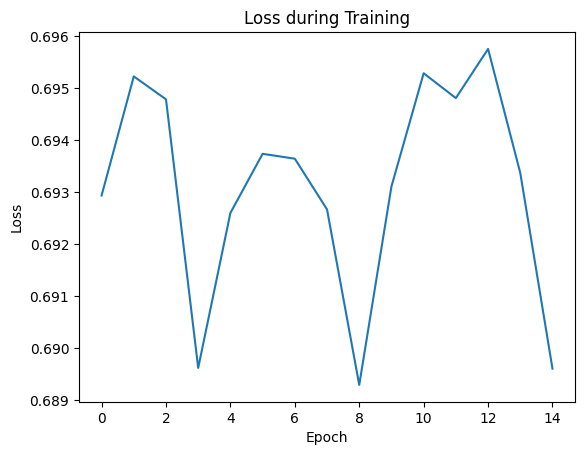

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.show()

In [ ]:
mlp_model.load_state_dict(torch.load("/content/drive/MyDrive/fusion_model/large_mlp_10000.pth"))

<ipython-input-29-f36c431709f7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load("/content/drive/MyDrive/fusion_model/large_mlp_10000.pt

<All keys matched successfully>

In [ ]:
# Créer un DataLoader
batch_size = 32
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    mlp_model.eval()
    correct = 0
    total = 0
    for images, labels in train_loader:
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Précision sur le dataset de test : {accuracy}%")
    print("✅ Test terminé.")

✅ Précision sur le dataset de test : 60.14%
✅ Test terminé.


In [ ]:
# Créer un DataLoader
batch_size = 32
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    mlp_model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Précision sur le dataset de test : {accuracy}%")
    print("✅ Test terminé.")

✅ Précision sur le dataset de test : 59.8%
✅ Test terminé.


In [ ]:
# Load the trained MLP model
#mlp_model.load_state_dict(torch.load("/content/drive/MyDrive/fusion_model/quickdraw_mlp_10000.pth"))
mlp_model.load_state_dict(torch.load("/content/drive/MyDrive/fusion_model/new_mlp_10000.pth"))
mlp_model.eval()

<ipython-input-33-09d260e14878>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load("/content/drive/MyDrive/fusion_model/quickdraw_mlp_1000

MLPClassifier(
  (fc1): Linear(in_features=328, out_features=164, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=164, out_features=62, bias=True)
  (fc3): Linear(in_features=62, out_features=2, bias=True)
)

1
Question: Peux-tu me dire si c'est un airplane ?
Prediction: Oui


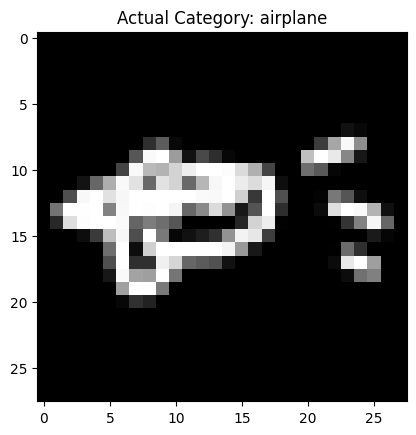

In [ ]:
# Example usage:
def predict_answer(image_vector, question):
    # Extract image features
    image_features = extract_image_features(image_vector)

    # Encode the question
    question_features = encode_question(question)

    # Fuse features
    fused_features = fuse_features(image_features, question_features)

    # Convert to tensor
    input_tensor = torch.tensor(fused_features, dtype=torch.float32).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = mlp_model(input_tensor)
        _, predicted = torch.max(output.data, 1)

    # Return prediction (0 or 1)
    return predicted.item()

# Example prediction
image_index = 1 # Choose an image index
image_vector = df.iloc[image_index]["image"]
question = "Peux-tu me dire si c'est un airplane ?"

prediction = predict_answer(image_vector, question)
print(prediction)
print(f"Question: {question}")
print(f"Prediction: {'Oui' if prediction == 1 else 'Non'}")

# Display the image
pic = image_vector.reshape(28, 28)
plt.imshow(pic, cmap='gray')
plt.title(f"Actual Category: {df.iloc[image_index]['Catégorie']}")
plt.show()
